# DOG BREED RECOGNITION
<br>

@author: Juarez Monteiro

---

## A ideia
Desenvolver um sistema simples de reconhecimento de raças de cachorro. Porém, com
uma dificuldade extra: adicionar raças que não foram vistas em tempo de treinamento, e
saber identificar *unknowns* (por exemplo, nossos queridos vira-latas).

## Primeira Parte
Na pasta **train** está um total de 100 raças de cachorros, uma em cada pasta. Num primeiro momento desenvolva um sistema que, dada uma foto de um cachorro destas raças, consiga dizer qual é a sua raça e com uma confiança desta predição.

---

# Dog Breed Model - Enhanced (ResNet-50)

---

# Acesse os dados de treinamento da ResNet-50 - Model Enhanced (FC) clicando [aqui](https://wandb.ai/jrzmnt/dog-breed-lightning/reports/Dog-Breed-Recognition-ResNet-50-Enhanced--VmlldzoxMTI4OTUx?accessToken=m3tjxn2hd854uapd0jjdl6pf1ccjckgamdvx43hkvobtgi3qre1l74mm69b71ch0)!


---

## Configuração do Modelo e Treinamento

Nesta sessão iremos instanciar o nosso modelo e iremos iniciar o treinamento do mesmo. Para isto, iremos utilizar a classe ```DogModel```. O modelo, *enhanced* em relação ao modelo de *baseline*, recebe como parâmetro o número de classes do problema (```num_classes=100```), e se queremos um modelo pré-treinado no ImageNet (```pre_trained=True```).

---

Para entendermos melhor algumas escolhas e como é o modelo **enhanced (fc)** são listadas as suas características a seguir:

- ### Topologia <br>
    - ResNet-50: Nessa versão, iremos utilizar a arquitetura ResNet-50 ([ResNet-50](https://pytorch.org/vision/0.8/_modules/torchvision/models/resnet.html)), por ser um modelo conhecido na área, e o qual as suas versões demonstram bons resultados na literatura ([Artigo ResNet](https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf), [Artigo de experimentação com ResNet](https://arxiv.org/abs/2110.00476));<br><br>

    - Para alguns casos o pré-treino (ImageNet) auxilia na convergência do modelo, fazendo com que o mesmo encontre o mínimo local de maneira mais rápida ([Artigo sobre Pré-treino](https://arxiv.org/abs/1811.08883)), dito isso, iremos utilizar um modelo pré-treinado no dataset ImageNet; <br><br>
    
- ### Pré-treino <br>
    - Para inicializarmos o pré-treino com a ResNet-18, iremos "congelar" todas as camadas do modelo, exceto as camadas ```fc.weight``` e ```fc.bias```; <br><br>
    
    - Com isso, nosso modelo irá aproveitar os pesos do ImageNet para as camadas anteriores, e irá treinar somente a camada toalmente conectada do nosso modelo; <br><br>
    
    - A ideia no primeiro momento é de aprendermos **características** (*features*) mais específicas do nosso problema, e deixarmos features mais abstratas, tais como bordas, etc., para os pesos aproveitados; <br><br>


- ### Learning Rate e Learning Rate Scheduler <br>
    - Como pode ser visto anteriormente, utilizamos um método para encontrarmos o melhor LR inicial para o modelo. E iremos utilizar o mesmo juntamente de um LR Scheduler para treinamento do nosso modelo; <br><br>
    
    - A imagem que representa a busca do melhor LR, nos mostra que um possível LR a ser escolhido será o valor de 1e-3, apesar do loss apresentado pelo método.
    
    - Utilizaremos o LR Scheduler ```ExponentialLR```, por ele funcionar muito bem com *Early Stopping*, e propor o que desejamos ([Pytorch ref.](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ExponentialLR.html)); <br><br>
    
    - A ideia é não só diminuirmos o tempo de construção da nossa função (modelo), como irmos degradando o valor do LR pouco a pouco para encontrarmos o *mínimo global* do problema; <br><br>
    
- ### Otimizador e Loss <br>
    - Como otimizador iremos utilizar o clássico `Adam` ([Artigo](https://arxiv.org/pdf/1412.6980.pdf)); <br>
        - "In practice Adam is currently recommended as the default algorithm to use", Andrej Karpathy ([CS231n](https://cs231n.github.io/)); <br><br>
        
    - Para o loss, foi escolhido o `CrossEntropyLoss` ([Pytorch ref.](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)), o qual juntamente com o Adam, segue uma escolha padrão para problemas de classificação.

---

Iniciaremos o código gerando o *import* de métodos e classes importantes para realizarmos o nosso objetivo

In [1]:
# regular imports
import os
import re
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import logging
from PIL import Image
from tqdm import tqdm

# sklearn imports
from sklearn.model_selection import train_test_split

# pytorch related imports
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import ExponentialLR
from torchvision import transforms
from torchvision import models
from torch.autograd import Variable

# lightning related imports
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning import Trainer

wandb: Currently logged in as: jrzmnt (use `wandb login --relogin` to force relogin)


In [ ]:
# import wandb and login
import wandb
!wandb login

Os métodos a seguir (`find_lr` e `plot_loss`) são utilizados na sessão de treinamento do modelo. Eles são responsáveis por encontrar um *learning rate* ideal dado um *data_loader*, um modelo, um otimizador e um loss. Após a fase de experimentação, o método `plot_loss` irá apresentar em uma figura o *loss* obtido pelo modelo utilizando diferentes valores de *learning rate*, e caberá a nós escolhermos o melhor.

In [2]:
def find_lr(train_loader, model, optimizer, criterion, init_value=1e-8, final_value=10., beta=0.98):
    """Perform Learning Rate Finder to check loss for each value of learning rate.

    Parameters
    ----------
    train_loader : torch.utils.data.DataLoader
        Dataloader that yields images and labels in batches.
    model : torchvision.models.resnet.ResNet
        ResNet model containing pre-trained weights.
    optimizer : torch.optim.<module>
        Type of optimizer.
    criterion : torch.nn.modules.loss.<module>
        Criterion to compute loss.
    init_value : float
        Initial learning rate value (minimum learning rate).
    final_value : float
        Final learning rate value (maximum learning rate).
    beta : float
        Normalization (smooth) value.
    """
    num = len(train_loader)-1
    mult = (final_value / init_value) ** (1/num)
    lr = init_value
    optimizer.param_groups[0]['lr'] = lr
    avg_loss = 0.
    best_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    
    for data in tqdm(train_loader):
        logging.info(f'Testing batch {batch_num} with LR: {lr}')
        batch_num += 1
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        avg_loss = beta * avg_loss + (1-beta) *loss.item()
        smoothed_loss = avg_loss / (1 - beta**batch_num)
        
        #Stop if the loss is exploding
        if batch_num > 1 and smoothed_loss > 4 * best_loss:
            return log_lrs, losses
        
        #Record the best loss
        if smoothed_loss < best_loss or batch_num==1:
            best_loss = smoothed_loss
            
        #Store the values
        losses.append(smoothed_loss)
        log_lrs.append(math.log10(lr))
        
        #Do step
        loss.backward()
        optimizer.step()
        
        #Update the lr for the next step
        lr *= mult
        optimizer.param_groups[0]['lr'] = lr
        
    return log_lrs, losses

In [3]:
def plot_loss(logs, losses, output=None):
    """Generate plot containing learning rate x loss.

    Parameters
    ----------
    logs : array
        List containing logs.
    losses : array
        List containing losses.
    output : string (optional)
        Path to save image in disk.
    """
    plt.clf()
    plt.figure(figsize=(10,5))
    plt.plot(logs[10:-5], losses[10:-5])
    plt.xlabel('Learning rate')
    plt.ylabel('Loss')
    plt.tight_layout()
    
    if output:
        logging.info(f'Plot saved at: {output}')
        plt.savefig(output)
        
    else:
        plt.show()

A seguir é criada a classe `DogDataset` com a principal função de sobreescever os métodos `__init__`, `__len__` e `__getitem__` oriundos da classe `Dataset` (`torch.utils.data`). Criamos a classe justamente para que a mesma seja adequada a realidade do nosso problema. A principal função a ser executada por essa classe é a de receber um indíce específico (`idx`) e retornar a imagem referente a este indíce juntamente ao id da classe desta imagem (`label_id`).

In [4]:
class DogDataset(Dataset):

    def __init__(self, file_list, class_dict, transform=None, phase=None):
        self.file_list = file_list
        self.class_dict = class_dict
        self.transform = transform
        self.phase = phase

    def __len__(self):
        return len(self.file_list)
    

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path).convert('RGB')

        # Transformimg Image
        img_transformed = self.transform(img, self.phase)

        # Get Label
        label = img_path.split('\\')[0].split('-')[-1]
        label_id = self.class_dict[label]

        return img_transformed, label_id

A classe ImageTransform é responsável por fornecer as modificações que desejamos nos conjuntos de imagens a serem criados (`dog_val`, `dog_train` e `dog_test`), dado o parâmetro `phase`, o qual indica qual conjunto de dados (treino, validação ou teste) estamos modificando. Essa classe irá conduzir o *data augmentation* quando necessário, bem como a normalização utilizando a média e desvio padrão do dataset (ImageNet), uma vez que iremos utilizar um modelo pré-treinado no mesmo.

In [5]:
class ImageTransform():

    def __init__(self, img_size=224, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):

        self.data_transform = {

            'train': transforms.Compose([
                transforms.RandomResizedCrop(img_size, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                #transforms.RandomRotation(degrees=(0, 180)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),

            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(img_size),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),

            'test': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(img_size),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }

    def __call__(self, img, phase):

        return self.data_transform[phase](img)

A classe `DogDataModule` será responsável por escanear e organizar nosso Dataset.

In [6]:
class DogDataModule(pl.LightningDataModule):
    def __init__(self, batch_size, data_dir: str = './../data/dogs/'):
        super().__init__()
        
        # images and dataset
        self.data_dir = data_dir
        self.train_data_dir = data_dir + 'train/'
        self.test_data_dir = data_dir + 'recognition/test/'
        
        self.batch_size = batch_size
        self.dims = (3, 224, 224)
        self.img_size = 224
        self.num_classes = 100
        self.class_dict = {}
        self.train_path_images = []
        self.test_path_images = []
        self.breeds = []

        self.train_split_path = []
        self.val_split_path = []
        self.dog_train = []
        self.dog_val = []
        self.dog_test = []
        
    def prepare_data(self):
        """Scan train_data_dir and test_data_dir to save all the train/test paths.
           It also creates train_dic to map the classes available to a scalar.
        """
        
        # Scan all train/val images
        for d in os.listdir(self.train_data_dir):
            dog_dir = os.path.join(self.train_data_dir, d)
    
            for img in os.listdir(dog_dir):
                img_path = os.path.join(dog_dir, img)
                self.train_path_images.append(img_path)
                self.breeds.append(img_path.split('\\')[0].split('-')[-1])
            
        self.breeds = set(self.breeds)
        
        for idx, breed in enumerate(self.breeds):
            self.class_dict[breed] = idx
        
        # Scan all test images
        for d in os.listdir(self.test_data_dir):
            dog_dir = os.path.join(self.test_data_dir, d)
    
            for img in os.listdir(dog_dir):
                img_path = os.path.join(dog_dir, img)
                self.test_path_images.append(img_path)
        
        print(50*'-')
        print(f'Images available for train/val: {len(self.train_path_images)}')
        print(f'Classes available for train/val: {len(self.breeds)}')
        print()
        print(f'Images available for test: {len(self.test_path_images)}')
        print(50*'-')
    
    def setup(self, stage=None):
        """Creates DogDataset objects, depends on which stage was passed

        Parameters
        ----------
        stage : string (optional)
            Name of the actual stage ('fit' or 'test')
        """
        
        # Assign train/val datasets for use in dataloaders
        if stage == 'fit' or stage is None:
            
            self.train_split_path, self.val_split_path = train_test_split(self.train_path_images, test_size=0.2)

            self.dog_train = DogDataset(self.train_split_path,
                                        self.class_dict,
                                        ImageTransform(self.img_size),
                                        phase='train')

            self.dog_val = DogDataset(self.val_split_path,
                                      self.class_dict,
                                      ImageTransform(self.img_size),
                                      phase='val')
            
        # Assign test dataset for use in dataloader(s)
        if stage == 'test':
            self.dog_test = DogDataset(self.test_path_images,
                                      self.class_dict,
                                      ImageTransform(self.img_size),
                                      phase='test')
        
    def random_plot_train_data(self):
        """Randomly pick an image from train_path_images to plot in the screen.
        
        """
        img_path = random.choice(self.train_path_images)
        img = Image.open(img_path)
        breed = img_path.split('\\')[0].split('-')[-1]
        
        print(breed)

        plt.imshow(img)
        plt.axis('off')
        plt.title(breed)
        plt.show()
    
    def train_dataloader(self):
        return DataLoader(self.dog_train, batch_size=self.batch_size, shuffle=True)
    
    
    def val_dataloader(self):
        return DataLoader(self.dog_val, batch_size=self.batch_size, shuffle=False)
    
    
    def test_dataloader(self):
        return DataLoader(self.dog_test, batch_size=self.batch_size, shuffle=False)


A classe `ImagePredictionLogger` a qual será um *callback* utilizado durante a fase de treino, será responsável por nos enviar um batch para validarmos e termos um *feedback* visual na ferramenta *wanbd*.

In [7]:
# This Callback allow us to verify the predictions for one batch while using wandb
class ImagePredictionLogger(Callback):
    def __init__(self, val_samples, num_samples=32):
        super().__init__()
        self.num_samples = num_samples
        self.val_imgs, self.val_labels = val_samples
        
    def on_validation_epoch_end(self, trainer, pl_module):
        # Bring the tensors to CPU
        val_imgs = self.val_imgs.to(device=pl_module.device)
        val_labels = self.val_labels.to(device=pl_module.device)
        
        # Get model prediction
        logits = pl_module(val_imgs)
        preds = torch.argmax(logits, -1)
        
        # Log the images as wandb Image
        trainer.logger.experiment.log({
            "examples":[wandb.Image(x, caption=f"Pred:{pred}, Label:{y}") 
                           for x, pred, y in zip(val_imgs[:self.num_samples], 
                                                 preds[:self.num_samples], 
                                                 val_labels[:self.num_samples])]
            })

Como o próprio nome já diz, a classe `DogModel` será responsável por instanciar nosso `model`. Nela, estão contidas informações da arquitetura da rede, métodos fundamentais como `training_step` e o `validation_step` que são responsáveis pela fase de treinamento.

In [11]:
class DogModel(pl.LightningModule):
    
    def __init__(self, input_shape, num_classes, learning_rate=2e-4, pre_trained=False):
        super().__init__()

        # log hyperparameters
        self.save_hyperparameters()
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.pre_trained = pre_trained
        self.params_to_update = []
        
        print(f'Use Pre-Training? {self.pre_trained}')
        self.feature_extractor = models.resnet50(pretrained=self.pre_trained)
        
        self.feature_extractor.eval()
        
        for param in self.feature_extractor.parameters():
            param.requires_grad = False
            
        n_sizes = self._get_conv_output(input_shape)
        
        self.classifier = nn.Linear(n_sizes, num_classes)
  
        # set CrossEntropy as the loss
        self.criterion = nn.CrossEntropyLoss()
        
        # set Adam as the optimizer
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        
        # set ExponentialLR as the scheduler
        self.lr_scheduler = ExponentialLR(self.optimizer, gamma=0.99)
        
                    
    # returns the size of the output tensor going into Linear layer from the conv block.
    def _get_conv_output(self, shape):
        batch_size = 1
        input = torch.autograd.Variable(torch.rand(batch_size, *shape))

        output_feat = self._forward_features(input) 
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size
    
    # returns the feature tensor from the conv block
    def _forward_features(self, x):
        x = self.feature_extractor(x)
        return x
    
        # will be used during inference
    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)
        x = F.log_softmax(self.classifier(x), dim=1)

        return x
    
    # set the optimizer and the scheduler chosen
    def configure_optimizers(self):
        return [self.optimizer], [self.lr_scheduler]

    # logic for a single training step
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        # training metrics
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)
        
        self.log('train_loss', loss, on_step=True, on_epoch=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, logger=True)

        return loss

    # logic for a single validation step
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        # validation metrics
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)
        
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        
        return loss

    # logic for a single testing step
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        # validation metrics
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)
        
        return loss

## Preparando os dados

In [9]:
# Initialize our data pipeline
dm = DogDataModule(batch_size=128)

# To access the x_dataloader we need to call prepare_data and setup.
dm.prepare_data()
dm.setup()

# Samples required by the custom ImagePredictionLogger callback to log image predictions.
val_samples = next(iter(dm.val_dataloader()))
val_imgs, val_labels = val_samples[0], val_samples[1]
val_imgs.shape, val_labels.shape

--------------------------------------------------
Images available for train/val: 17097
Classes available for train/val: 100

Images available for test: 1030
--------------------------------------------------


(torch.Size([128, 3, 224, 224]), torch.Size([128]))

### Plotando uma imagem aleatória para conferirmos nossos dados

haired_fox_terrier


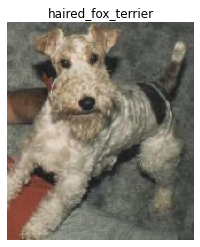

In [10]:
# let's plot a random image from our train dataset
dm.random_plot_train_data()

---

## Encontrando o melhor Learning Rate Inicial

A ideia nesta etapa é utilizarmos o nosso **modelo**, o nosso **otimizador** e o nosso **loss**, para encontrarmos o melhor Learning Rate inicial possível. Para isso, é utilizado o método `find_lr`, disponível no início desse jupyter notebook. A ideia inicial era ter utilizado o `LR finder` do *Pytorch Lightning* ([link](https://pytorch-lightning.readthedocs.io/en/latest/advanced/lr_finder.html)), todavia o mesmo espera que o objeto da classe `Model` (`DogModel`, no nosso caso) possua métodos de retorno de `DataLoader`, tais como: `train_dataloader`, `val_dataloader` e `test_dataloader`. Neste código, optamos por deixar separado esses métodos mencionados, justamente para o modelo ser independente por si só. Com isso, implementamos tais métodos na classe `DogDataModule` e utilizamos um método definido neste notebook para realizar o papel do `LR finder`.



In [11]:
# primeiro passo é instanciar um modelo para encontrar o melhor lr utilizando o train_data_loader
model = DogModel(dm.size(), dm.num_classes, pre_trained=True)

Use Pre-Training? True


A:\torch\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


#### Atenção: a última execução levou em torno de 20 minutos para encontrar o melhor LR.

In [12]:
log_lrs, losses = find_lr(dm.val_dataloader(), model, model.optimizer, model.criterion)

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 26/27 [09:21<00:21, 21.61s/it]


<Figure size 432x288 with 0 Axes>

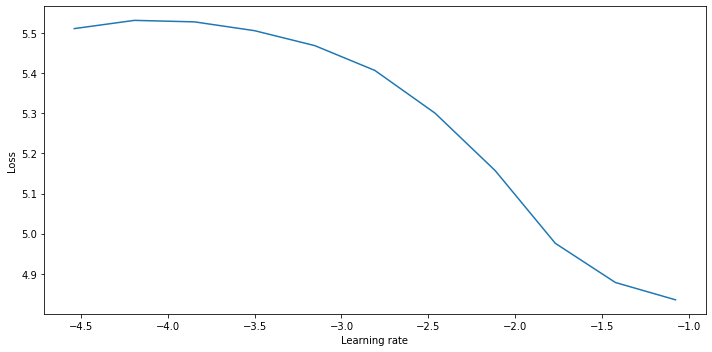

In [13]:
plot_loss(log_lrs, losses, output='./../reports/figures/resnet50_enhanced_lr_finder_validation.png')

## Criando nosso modelo *baseline* e definindo os *callbacks*

**Atenção!**
Perceba que foi utilizado a ferramenta [wandb](https://wandb.ai/) para acompanharmos o pipeline de treinamento dos modelos. Por isso é fundamental que o usuário que for executar esse notebook (e outros desse projeto), tenha criado uma conta e baixado corretamenta a ferramenta.

In [14]:
early_stop_callback = EarlyStopping(
   monitor='val_loss',
   patience=10,
   verbose=False,
   mode='min'
)

In [15]:
MODEL_CKPT_PATH = './../models/'
MODEL_CKPT = 'resnet-50/save-{epoch:02d}-{val_loss:.2f}'

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath=MODEL_CKPT_PATH,
    filename=MODEL_CKPT ,
    save_top_k=1,
    mode='min')

A:\torch\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:446: UserWarning: Checkpoint directory ./../models/ exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


In [21]:
# Init our model
model = DogModel(dm.size(), dm.num_classes, learning_rate=1e-3, pre_trained=True)

# Initialize wandb logger
wandb_logger = WandbLogger(project='dog-breed-lightning', job_type='train')

# Monitor to follow lr using wandb
lr_monitor = LearningRateMonitor(logging_interval='epoch')

Use Pre-Training? True


In [22]:
# Initialize a trainer
trainer = Trainer(logger=wandb_logger,
                  default_root_dir='./logs/',
                  gpus=[0],
                  callbacks=[early_stop_callback,
                             ImagePredictionLogger(val_samples),
                             lr_monitor, checkpoint_callback])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [23]:
# log gradients and model topology
wandb_logger.watch(model)

# Acesse o treinamento da ResNet-50 - Model Enhanced (FC) clicando [aqui](https://wandb.ai/jrzmnt/dog-breed-lightning/reports/Dog-Breed-Recognition-ResNet-50-Enhanced--VmlldzoxMTI4OTUx?accessToken=m3tjxn2hd854uapd0jjdl6pf1ccjckgamdvx43hkvobtgi3qre1l74mm69b71ch0)!

### Treinando o Modelo

In [24]:
# Train the model
trainer.fit(model, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type             | Params
-------------------------------------------------------
0 | feature_extractor | ResNet           | 25.6 M
1 | classifier        | Linear           | 100 K 
2 | criterion         | CrossEntropyLoss | 0     
-------------------------------------------------------
100 K     Trainable params
25.6 M    Non-trainable params
25.7 M    Total params
102.629   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

A:\torch\lib\site-packages\deprecate\deprecation.py:115: LightningDeprecationWarning: The `accuracy` was deprecated since v1.3.0 in favor of `torchmetrics.functional.classification.accuracy.accuracy`. It will be removed in v1.5.0.
  stream(template_mgs % msg_args)
A:\torch\lib\site-packages\pytorch_lightning\trainer\data_loading.py:106: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [25]:
# Close wandb run
wandb.finish()

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
lr-Adam,█▇▇▆▆▅▅▄▄▃▃▂▂▁
train_acc_epoch,▁▆▆▇▇▇█▇▇█████
train_acc_step,▁▃▅▅▅▄▄▃▆▄█▅▇▆▇▆▅▇▅▆▅▅▅▆▅▇▆▆▇
train_loss_epoch,█▃▂▂▂▂▁▁▁▁▁▁▁▁
train_loss_step,██▅▄▅▅▅▆▂▄▁▃▂▄▁▃▃▁▆▂▄▄▄▂▄▁▃▂▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_acc,▁▆▅▇▇█▅▅▆█▄▅▆▅
val_loss,▇▃▃▁▃▃▄▅▅▅▆█▅█
epoch,13
lr-Adam,0.00088


### Importante!

Sem o código da célula abaixo, não seriámos capazes de carregar os pesos deste treinamento (apesar do callback salvando os pesos).

In [26]:
run = wandb.init(project='wandb-lightning', job_type='producer')

artifact = wandb.Artifact('model', type='model')
artifact.add_dir(MODEL_CKPT_PATH)

run.log_artifact(artifact)
run.join()

wandb: Adding directory to artifact (.\..\models)... Done. 9.4s


## Gerando Predição do Modelo (validation)

In [27]:
MODEL_CKPT_PATH = './../models/resnet-50/'

In [28]:
model_ckpts = os.listdir(MODEL_CKPT_PATH)
losses = []
for model_ckpt in model_ckpts:
    loss = re.findall("\d+\.\d+", model_ckpt)
    losses.append(float(loss[0]))

losses = np.array(losses)
best_model_index = np.argsort(losses)[0]
best_model = model_ckpts[best_model_index]
print(best_model)

save-epoch=03-val_loss=0.44.ckpt


In [29]:
inference_model = DogModel.load_from_checkpoint(MODEL_CKPT_PATH+'/'+best_model)

Use Pre-Training? True


In [30]:
from sklearn.metrics import accuracy_score

def evaluate(model, loader):
    model.eval()
    y_true = []
    y_pred = []
    
    y_true_batch = []
    y_pred_batch = []
    
    batch = 0
    
    for imgs, labels in tqdm(loader):
        batch += 1
        logits = inference_model(imgs)

        y_true.extend(labels)
        y_pred.extend(np.argmax(logits.detach().numpy(), axis=1))
        
    print(f'Model Acc: {accuracy_score(y_true, y_pred)}')
    
    return np.array(y_true), np.array(y_pred)

In [31]:
y_true, y_pred = evaluate(inference_model, dm.val_dataloader())


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [08:27<00:00, 18.79s/it]

Model Acc: 0.8587719298245614


### Verificando a Acurácia do modelo

In [32]:
accuracy_score(y_true, y_pred)

0.8587719298245614

In [33]:
results = [y_true, y_pred]
file_path = './../reports/results/resnet50-validation-results-ytrue-ypred.npy'
np.save(file_path, results)

---

# Analisando o Resultado

Os resultados do modelo **ResNet-18 Baseline** podem ser visualizados ao acessar o notebook **Dog-Breed-Results.ipynb** o qual esta localizado nesta pasta (`'./notebooks'`).